### Semi-autonomous Teleoperation Demo : Place task in `Office` scene

### Parse `Realistic Scene`

In [2]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[3.1.4]


In [3]:
xml_path = '../../../asset/scene_office_bookshelf.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-0.05,0.80,0])

jntadr_mug_cup = env.model.body('mug_cup').jntadr[0]
env.model.joint(jntadr_mug_cup).qpos0[:3] = np.array([0.5, -0.4, 0.81])
env.model.joint(jntadr_mug_cup).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, np.random.rand() * 360])))
env.model.body('shelf_row1').pos = np.array([0.8,0.3,0.75])
env.model.body('shelf_row1').quat = r2quat(rpy2r(np.radians([0, 0, 90])))

obj_box_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_box"))]
obj_wine_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_wine"))]
obj_book_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("book"))]

# Place objects
n_box_obj = len(obj_box_names)
env.place_objects_random(n_obj=n_box_obj, obj_names=obj_box_names, x_range=[0.80, 1.15], y_range=[-3.15, -2.15], COLORS=False, VERBOSE=True)
n_wine_obj = 3
env.place_objects_random(n_obj=n_wine_obj, obj_names=obj_wine_names, x_range=[0.80, 0.85], y_range=[0.3, 0.5], z_range=[1.35,1.35], min_dist=0.05, COLORS=False, VERBOSE=True)

env.model.joint(env.model.body('mug_cup').jntadr[0]).qpos0[:3] = np.array([-8, 0.45, 1.55])

# Book1 is target_object
env.model.joint(env.model.body('book2').jntadr[0]).qpos0[:3] = np.array([0.80, 0.30, 1.03])
env.model.joint(env.model.body('book3').jntadr[0]).qpos0[:3] = np.array([0.82, 0.35, 1.03])
env.model.joint(env.model.body('book4').jntadr[0]).qpos0[:3] = np.array([0.79, 0.40, 1.03])
env.model.joint(env.model.body('book5').jntadr[0]).qpos0[:3] = np.array([0.84, 0.45, 1.03])
env.model.joint(env.model.body('book6').jntadr[0]).qpos0[:3] = np.array([0.8, 0.25, 0.8])
env.model.joint(env.model.body('book7').jntadr[0]).qpos0[:3] = np.array([0.81, 0.29, 0.80])
env.model.joint(env.model.body('book8').jntadr[0]).qpos0[:3] = np.array([0.79, 0.38, 0.80])
env.model.joint(env.model.body('book9').jntadr[0]).qpos0[:3] = np.array([0.8, 0.45, 0.80])
env.model.joint(env.model.body('book10').jntadr[0]).qpos0[:3] = np.array([0.83, 0.49, 0.80])

env.model.joint(env.model.body('book1').jntadr[0]).qpos0[:3] = np.array([0.2, -0.4, 0.8])
env.model.joint(env.model.body('book1').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.array([1.57, 0, 0])))


window
obj_wine_01: [0.81 0.48 1.35]
obj_wine_02: [0.82 0.43 1.35]
obj_wine_03: [0.81 0.32 1.35]


In [4]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()

# init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
init_ur_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])

env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000

i = 0

while env.get_sim_time() <= max_sec:    
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    # env.model.geom_size[env.model.body('obj_box_03').geomadr[0]] += np.array([0.0001,0.0001,0.0001])
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] # + np.array([0,0,-0.2])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

# Close viewer
env.close_viewer()

[ 0.35 -0.13  1.16]
Pressed ESC
Quitting.


2025-06-14 13:46:29.173 python[66778:1880365] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


### Get all `the Physically Plausible` positions

In [5]:
def uniform_sample_position(x_range, y_range, z_range, n_sample):
    x_values = np.linspace(x_range[0], x_range[1], 10)
    y_values = np.linspace(y_range[0], y_range[1], 10)
    z_values_floor1 = np.linspace(z_range[0], 1.2, 5)
    z_values_floor2 = np.linspace(1.2, z_range[1], 5)
    
    positions = []
    for x in x_values:
        for y in y_values:
            for z1 in z_values_floor1:  # 1st floor
                positions.append((x, y, z1))
            for z2 in z_values_floor2:  # 2nd floor
                positions.append((x, y, z2))
    
    return np.array(positions)

x_range = np.array([0.4, 1.25])
y_range = np.array([-0.55, 0.55])
# 0.8m: 1st floor, 0.8m: 2nd floor
z_range = np.array([0.8, 1.5])

n_sample = 15
uniform_positions = uniform_sample_position(x_range, y_range, z_range, n_sample)
uniform_positions.shape

(1000, 3)

In [6]:
# Wine / Shelves
def get_geom_region_type1(env, obj_name):
    center_x, center_y, center_z, size_w, size_h, size_d = env.model.geom_aabb[env.model.body(obj_name).geomadr][0]
    obj_pos_x, obj_pos_y, obj_pos_z = env.get_p_body(obj_name)
    obj_R = env.get_R_body(obj_name)
    
    # Get the corners of the object based on the lower corner
    corners = np.array([
        # [center_x - size_w, center_y - size_h, center_z - size_d],
        [center_x - size_w*0.9, center_y - size_h, center_z + size_d],
        # [center_x - size_w, center_y + size_h, center_z - size_d],
        [center_x - size_w*0.9, center_y + size_h, center_z + size_d],
        # [center_x + size_w, center_y - size_h, center_z - size_d],
        [center_x + size_w*0.9, center_y - size_h, center_z + size_d],
        # [center_x + size_w, center_y + size_h, center_z - size_d],
        [center_x + size_w*0.9, center_y + size_h, center_z + size_d],
    ])
    
    # Consider Rotation and Translation of the obj_name
    corners = np.matmul(corners, obj_R.T) + np.array([obj_pos_x, obj_pos_y, obj_pos_z])

    return corners

# Books / Cylinder
def get_geom_region_type2(env, obj_name):
    center_x, center_y, center_z, size_w, size_h, size_d = env.model.geom_aabb[env.model.body(obj_name).geomadr][0]
    # size_w, size_h, size_d = env.model.geom_size[env.model.body(obj_name).geomadr][0]
    obj_pos_x, obj_pos_y, obj_pos_z = env.get_p_body(obj_name)
    obj_R = env.get_R_body(obj_name)
    
    # Get the corners of the object
    corners = np.array([
        [center_x - size_h, center_y - size_w/2, center_z],
        [center_x - size_h, center_y - size_w/2, center_z + 2*size_d],
        [center_x - size_h, center_y + size_w/2, center_z],
        [center_x - size_h, center_y + size_w/2, center_z + 2*size_d],
        [center_x + size_h, center_y - size_w/2, center_z],
        [center_x + size_h, center_y - size_w/2, center_z + 2*size_d],
        [center_x + size_h, center_y + size_w/2, center_z],
        [center_x + size_h, center_y + size_w/2, center_z + 2*size_d],
    ])
    # Consider Rotation and Translation of the obj_name
    corners = np.matmul(corners, obj_R.T) + np.array([obj_pos_x, obj_pos_y, obj_pos_z])

    return corners

# Avoiding Table / Mug cup
def get_geom_region_type3(env, obj_name):
    center_x, center_y, center_z, size_w, size_h, size_d = env.model.geom_aabb[env.model.body(obj_name).geomadr][0]
    # size_w, size_h, size_d = env.model.geom_size[env.model.body(obj_name).geomadr][0]
    obj_pos_x, obj_pos_y, obj_pos_z = env.get_p_body(obj_name)
    obj_R = env.get_R_body(obj_name)
    
    # Get the corners of the object
    corners = np.array([
        # [center_x - size_w, center_y - size_h, center_z],
        [center_x - size_w*0.9, center_y - size_h*0.9, center_z + 2*size_d],
        # [center_x - size_w, center_y + size_h, center_z],
        [center_x - size_w*0.9, center_y + size_h*0.9, center_z + 2*size_d],
        # [center_x + size_w, center_y - size_h, center_z],
        [center_x + size_w*0.9, center_y - size_h*0.9, center_z + 2*size_d],
        # [center_x + size_w, center_y + size_h, center_z],
        [center_x + size_w*0.9, center_y + size_h*0.9, center_z + 2*size_d],
    ])
    # Consider Rotation and Translation of the obj_name
    corners = np.matmul(corners, obj_R.T) + np.array([obj_pos_x, obj_pos_y, obj_pos_z])

    return corners

def fill_object(vertices, resolution):
    # Assuming vertices is a list of 8 vertices of an axis-aligned box
    min_x = min(v[0] for v in vertices)
    max_x = max(v[0] for v in vertices)
    min_y = min(v[1] for v in vertices)
    max_y = max(v[1] for v in vertices)
    min_z = min(v[2] for v in vertices)
    max_z = max(v[2] for v in vertices)

    # Creating points using linspace
    x_points = np.linspace(min_x, max_x, resolution[0])
    y_points = np.linspace(min_y, max_y, resolution[1])
    z_points = np.linspace(min_z, max_z, resolution[2])

    # Creating a meshgrid for the points
    x, y, z = np.meshgrid(x_points, y_points, z_points, indexing='ij')

    # Reshaping to get a list of points
    points = np.vstack((x.ravel(), y.ravel(), z.ravel())).T

    return points

[ 0.5  -0.01  1.16]
Pressed ESC
Quitting.


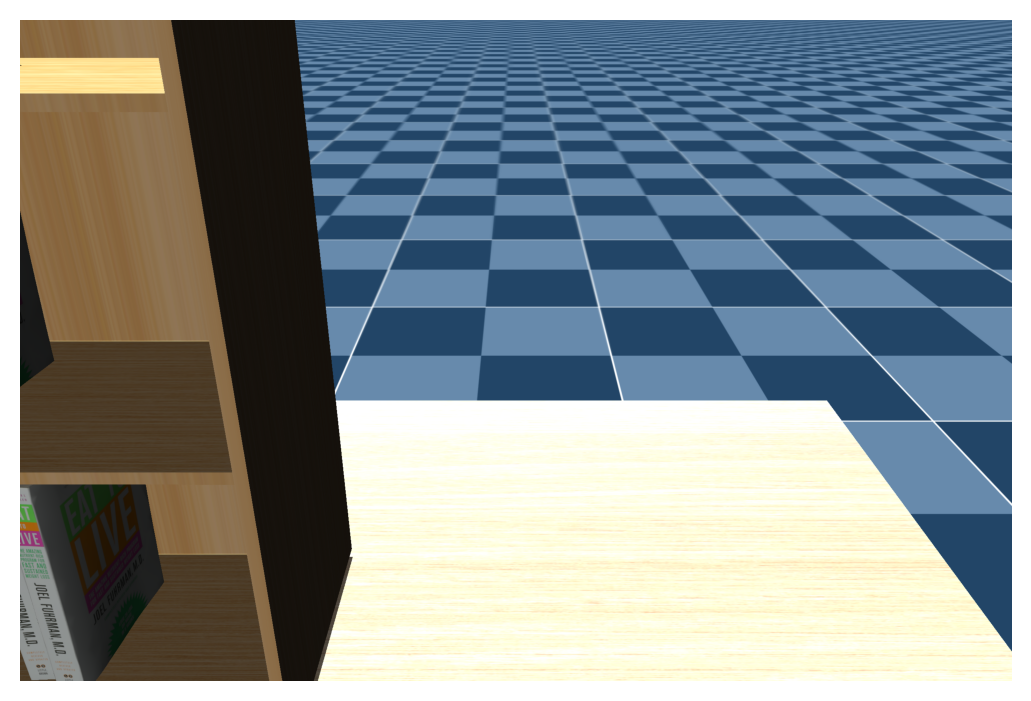

Done. Tick:[502] Time:[1.00]sec


In [7]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()
# init_ur_q = np.array([0,0,0,0,np.deg2rad(90),0])
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break
        
    # Render
    if env.loop_every(HZ=20):
        # Example bounding box data (center, size)
        resolution = (10, 10, 5)  # Number of points along each axis
        points = fill_object(get_geom_region_type1(env, 'shelf_row1'), resolution)
        [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in points]
        points = fill_object(get_geom_region_type1(env, 'shelf_row2'), resolution)
        [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0.,0,1]) for sampled_place_ in points]
        points = fill_object(get_geom_region_type1(env, 'shelf_row3'), resolution)
        [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0.,0,1]) for sampled_place_ in points]

        # [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in get_geom_region_type1(env, 'shelf_row1')]
        # [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in get_geom_region_type1(env, 'shelf_row2')]
        # [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in get_geom_region_type1(env, 'shelf_row3')]

        env.render(render_every=1)
        

plt.imshow(rgb_img) 
plt.axis('off')
plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

#### Store all the geometry regions

In [8]:
resolution = (10, 10, 5)  # Number of points along each axis
obj_shelf_row1_region = fill_object(get_geom_region_type1(env, 'shelf_row1'), resolution)
obj_shelf_row2_region = fill_object(get_geom_region_type1(env, 'shelf_row2'), resolution)
obj_shelf_row3_region = fill_object(get_geom_region_type1(env, 'shelf_row3'), resolution)

stacked_geom_region = np.vstack([
    obj_shelf_row1_region, obj_shelf_row2_region, obj_shelf_row3_region,
])

stacked_geom_region.shape

(1500, 3)

#### Screen geom regions considering z-axis offset

In [9]:
from utils.util import passthrough_filter, remove_duplicates_with_threshold

pcd_masked = passthrough_filter(stacked_geom_region, axis=0, interval=[0.4, 1.1])
pcd_masked = passthrough_filter(pcd_masked, axis=2, interval=[0.7, 1.3])
pcd_masked += np.array([0, 0, 0.05])
print(pcd_masked.shape)

threshold = 0.05
filtered_pcd = remove_duplicates_with_threshold(pcd_masked, threshold)
print(filtered_pcd.shape)


(1500, 3)
(105, 3)


### Get place !!!

In [10]:
env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pith", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

# filtered_pcd = np.load('./data/feasible_pcd_20230906_c48_g4_worker48_5.npy')

In [12]:
import time

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.,distance=1.5,elevation=-80,lookat=([0.44, 0.  , 1.33]),
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

env.reset()
# Start from initial configuration
capture_pose_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]
env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])

tick = 0
end_tick = 1000
target_obj_name = 'book1' # 'coke'
target_cylinder_jntadr = env.model.body(target_obj_name).jntadr[0]
print(env.get_p_body(target_obj_name)[0])
p_list = []
R_list = []
feasible_place_positions = []
target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]

env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pitch", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

for p in filtered_pcd:
    p_list = []
    R_list = []
    quat_list = []
    p += np.array([0, 0, 0.0])
    print(f"Position: {p}")
    start = env.tick
    p_copy = p
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = p_copy
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 0, 0])))
    while env.tick - start < end_tick:
        env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])
        env.step(ctrl=capture_pose_q,ctrl_idxs=[0,1,2,3,4,5])
        R_obj = env.get_R_body(target_obj_name)
        quat_ = r2quat(R_obj)
        quat_list.append(quat_)
        _,f_contacts,_,_,body1s,body2s = env.get_contact_info(must_include_prefix=target_obj_name)
        print(f"f_contacts: {np.max(np.linalg.norm(np.array(f_contacts)[:,0]))}")
        env.plot_sphere(p=p_copy, r=0.005, rgba=[0,1,0,1], label=f"{env.tick}/{end_tick}")
        [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.7,0,0.7,0.1]) for sampled_place_ in filtered_pcd]

        env.plot_data(name="x", data=np.array(env.get_p_body(target_obj_name))[0], fig_idx=0)
        env.plot_data(name="y", data=np.array(env.get_p_body(target_obj_name))[1], fig_idx=0)
        env.plot_data(name="z", data=np.array(env.get_p_body(target_obj_name))[2], fig_idx=0)

        env.plot_data(name="Roll", data=r2rpy(env.get_R_body(target_obj_name))[0], fig_idx=1)
        env.plot_data(name="Pitch", data=r2rpy(env.get_R_body(target_obj_name))[1], fig_idx=1)
        env.plot_data(name="Yaw", data=r2rpy(env.get_R_body(target_obj_name))[2], fig_idx=1)
 
        env.plot_data(name="Q_w", data=env.data.qpos[target_obj_qposadr+3], fig_idx=2)
        # env.plot_data(name="Q_x", data=env.data.qpos[target_obj_qposadr+4], fig_idx=2)
        # env.plot_data(name="Q_y", data=env.data.qpos[target_obj_qposadr+5], fig_idx=2)
        # env.plot_data(name="Q_z", data=env.data.qpos[target_obj_qposadr+6], fig_idx=2)
        if not env.is_viewer_alive(): break
        env.render(render_every=5)
    
    env.reset()
    print(f"max_f_contact: {np.max(np.array(f_contacts))}")
    lower_bound = 0.70
    upper_bound = 0.79
    in_range = np.logical_and(np.array(quat_list)[5:][:,0] >= lower_bound, np.array(quat_list)[5:][:,0] <= upper_bound)
    all_in_range = np.all(in_range)
    # print(f"all_in_range: {all_in_range}")
    # print(f"max_qw: {np.max(np.array(quat_list)[5:][:,0])}")
    # print(f"min_qw: {np.min(np.array(quat_list)[5:][:,0])}")

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

0.2
Position: [0.69 0.08 0.81]
f_contacts: 28.817938650579876
f_contacts: 40.33444921572946
f_contacts: 51.465548298110065
f_contacts: 47.30355916176615
f_contacts: 30.061299070091877
f_contacts: 21.157861915045014
f_contacts: 21.243877028889745
f_contacts: 21.066608953098225
f_contacts: 20.631675651411456
f_contacts: 20.213802585220105
f_contacts: 19.68827999724695
f_contacts: 29.748615368383597
f_contacts: 28.805057224686248
f_contacts: 27.86638648520377
f_contacts: 36.789522618947785
f_contacts: 43.87132460684194
f_contacts: 55.06945988251235
f_contacts: 47.01207433635613
f_contacts: 38.50993249392206
f_contacts: 36.61734172843214
f_contacts: 21.30794884356478
f_contacts: 20.30608250262142
f_contacts: 19.439020729247897
f_contacts: 18.672724291198673
f_contacts: 17.98353558476285
f_contacts: 17.34479577204874
f_contacts: 23.685499675876816
f_contacts: 22.962197691692182
f_contacts: 21.998507468060616
f_contacts: 21.080609917158466
f_contacts: 20.262503633732084
f_contacts: 13.776105

### Test on `the phyiscally plausible place`

[ 0.5  -0.01  1.16]
R_body: [ 1.55 -0.04 -0.  ]
Tick: 500
Pressed ESC
Quitting.


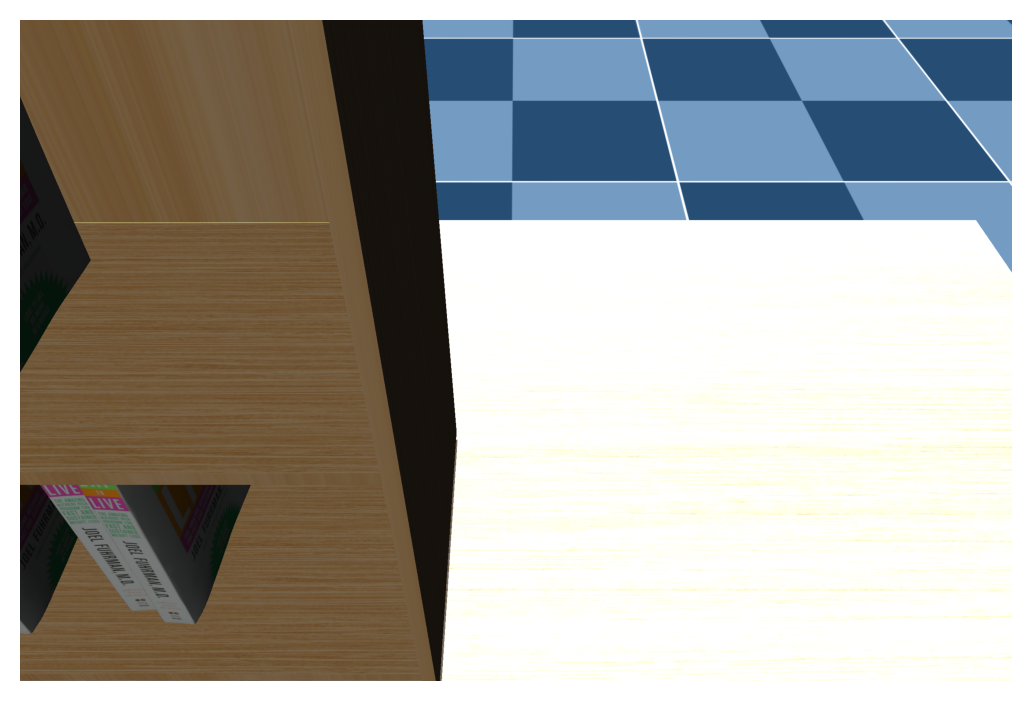

Done. Tick:[927] Time:[1.85]sec


In [13]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0,distance=3.0,elevation=-90,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Reset
env.reset()
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
print(env.get_p_body('tcp_link'))
target_obj_name = 'book1'
target_cylinder_jntadr = env.model.body(target_obj_name).jntadr[0]
qposadr = env.model.jnt_qposadr[target_cylinder_jntadr]

tick,max_sec,pcd_tick = 0,1000,0
while env.get_sim_time() <= max_sec:
    if env.tick % 500 == 0:
        env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = p_copy
        env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 0, 0])))
        print(f"R_body: {r2rpy(env.get_R_body(target_obj_name))}")
        print(f"Tick: {env.tick}")
        pcd_tick += 1
        if pcd_tick >= len(feasible_place_positions):
            # pcd_tick = len(feasible_place_positions) - 1
            pcd_tick = 0

    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)

    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

        # [env.plot_sphere(p=sampled_place_+np.array([0,0,0.05]), r=0.008, rgba=[0,0,1,1]) for sampled_place_ in np.array(feasible_place_positions)]

        for p in feasible_place_positions: env.plot_sphere(p=p,r=0.005,rgba=[0.95,0.05,0.05,1])
        env.render(render_every=1)
        

plt.imshow(rgb_img) 
plt.axis('off')
plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

#### Solve IK: random sample from the candidate positions

In [18]:
env.init_viewer(viewer_title='IK solver',viewer_width=1200,viewer_height=800,viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset() # reset

# p_target = np.array([0.8, 0.3, 1.3])
p_target = np.array([0.60, 0.35, 1.16])
R_target = rpy2r(np.array([-180,0,90])*np.pi/180.0)
q_init = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])
q_init_upright = np.array([0,-np.pi/2,0,0,np.pi/2,0])
q_ik_target = env.solve_ik_repel(
    body_name='tcp_link',p_trgt=p_target,R_trgt=R_target,
    IK_P=True,IK_R=True, q_init=q_init,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False, DO_RENDER=True, th=1, err_th=1e-2, stepsize=1, w_weight=0.3, render_every=1.0, repulse=0, VERBOSE=False)

print(f"Initial Joint values: {q_init}")
print(f"Solved IK: {q_ik_target}")

# Close viewer
env.close_viewer()
print ("Done.")

Initial Joint values: [-3.14 -0.52 -2.09  2.18 -1.57  0.  ]
Solved IK: [-1.61 -1.59 -1.85  3.14 -0.05  0.28]
Done.


### Trajectory planning phase: `Quintic` method

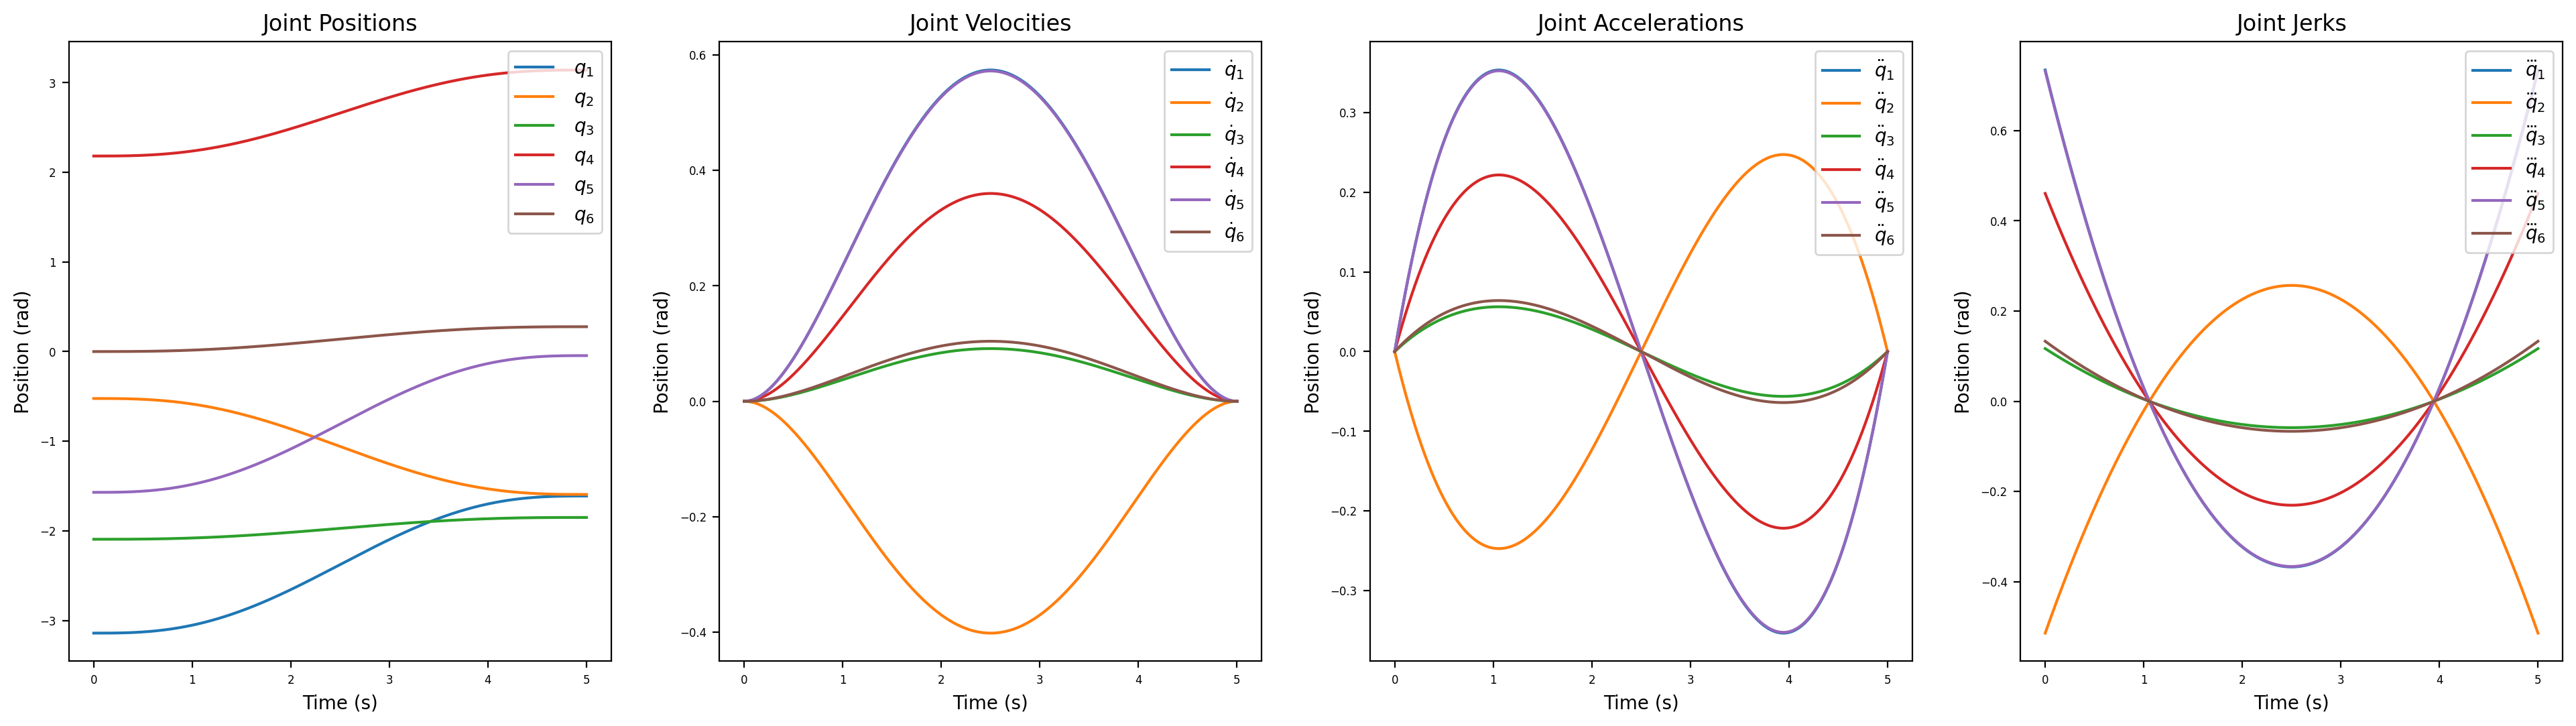

In [19]:
from utils.util import quintic_trajectory

# Define the conditions of the trajectory
q_init = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
q_init = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])
start_pos = q_init
start_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
start_acc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
end_pos = q_ik_target
end_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
end_acc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
duration = 5.0  # Time to complete trajectory.
num_points = int(duration / env.dt)
max_velocity = 2.0
max_acceleration = 2.0

positions, velocities, accelerations, jerks = quintic_trajectory(start_pos, start_vel, start_acc, end_pos, end_vel, end_acc, duration, num_points, max_velocity, max_acceleration)

time_step = np.linspace(0, duration, num_points)
plt.figure(figsize=(24, 6))
plt.subplot(1, 4, 1)
for i in range(6):
    plt.plot(time_step, positions[:, i], label=rf"$\ q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Positions")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 4, 2)
for i in range(6):
    plt.plot(time_step, velocities[:, i], label=rf"$\dot q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Velocities")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 4, 3)
for i in range(6):
    plt.plot(time_step, accelerations[:, i], label=rf"$\ddot q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Accelerations")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 4, 4)
for i in range(6):
    plt.plot(time_step, jerks[:, i], label=rf"$\dddot q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Jerks")
plt.legend(loc='upper right')
plt.show()

In [20]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[1.0,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

p_eef_list = []
for q in positions:
    env.forward(q=q, joint_idxs=env.idxs_forward)
    p_eef_list.append(env.get_p_body('tcp_link'))
p_eef_list_np = np.array(p_eef_list)[::30]  # downsample to visualize with markers.

env.forward(q=q_init, joint_idxs=env.idxs_forward)

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    # env.step(ctrl=q_init, ctrl_idxs=env.idxs_step)
    print(env.get_p_body('tcp_link'))
    if tick >= len(positions):
        env.step(ctrl=positions[-1,:], ctrl_idxs=env.idxs_forward)
    else:    
        env.step(ctrl=positions[tick,:], ctrl_idxs=env.idxs_forward)
        
    # Render
    for p_eef in p_eef_list_np: 
        env.plot_sphere(p=p_eef, r=0.01, rgba=[0.5,0.5,0.5,0.01])
    env.render(render_every=10)

# Close viewer
env.close_viewer()
print ("Done.")

[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]


In [21]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[1.0,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

p_eef_list = []
for q in positions:
    env.forward(q=q, joint_idxs=env.idxs_forward)
    p_eef_list.append(env.get_p_body('tcp_link'))
p_eef_list_np = np.array(p_eef_list)[::30]  # downsample to visualize with markers.

env.forward(q=q_init, joint_idxs=env.idxs_forward)

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    if tick >= len(positions):
        env.step(ctrl=positions[-1,:], ctrl_idxs=env.idxs_forward)
    else:    
        env.step(ctrl=positions[tick,:], ctrl_idxs=env.idxs_forward)
        
    env.render(render_every=10)

# Close viewer
env.close_viewer()
print ("Done.")

Pressed ESC
Quitting.
Done.
